In [5]:
import os
import sys
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from scripts.models import build_cnn_scratch, build_transfer_model
from scipy.io import loadmat

os.chdir('..')
print("📂 Working Directory :", os.getcwd())

# --- Simulation d'arguments comme dans argparse ---
class Args:
    model = 'scratch'           # 'scratch' ou 'transfer'
    custom_aug = False           # True = augmentation perso
    batch_size = 32
    epochs = 2
    img_size = 224
    train_mat = 'data/raw/train_list.mat'
    val_mat = 'data/raw/test_list.mat'
    data_dir = 'data/processed/Images'
    output = 'models/best_model.h5'

args = Args()

# --- Fonction principale ---
def train_model(args):
    def load_file_list(mat_path):
        print(f"⚙️ Chargement du fichier .mat depuis : {mat_path}")
        mat = loadmat(mat_path)
        return [item[0][0] for item in mat["file_list"]]

    train_list = load_file_list(args.train_mat)
    val_list = load_file_list(args.val_mat)

    def get_label_from_path(path):
        return path.split('/')[0]

    train_labels = [get_label_from_path(p) for p in train_list]
    val_labels = [get_label_from_path(p) for p in val_list]

    train_paths = [os.path.join(args.data_dir, path) for path in train_list]
    val_paths = [os.path.join(args.data_dir, path) for path in val_list]

    train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})

    # --- Générateurs ---
    if args.custom_aug:
        print("🧪 Utilisation du générateur personnalisé avec augmentation.")
        from scripts.augmentation_data import load_and_augment_images, display_augmented_images

        class_names = sorted(set(train_labels))
        class_to_idx = {name: idx for idx, name in enumerate(class_names)}
        num_classes = len(class_to_idx)

        train_encoded = [class_to_idx[label] for label in train_labels]
        val_encoded = [class_to_idx[label] for label in val_labels]

        train_labels_cat = to_categorical(train_encoded)
        val_labels_cat = to_categorical(val_encoded)

        train_gen = load_and_augment_images(
            train_list, train_labels_cat, args.batch_size,
            target_size=(args.img_size, args.img_size),
            processed_images_dir=args.data_dir
        )

        val_datagen = ImageDataGenerator(rescale=1./255)
        val_gen = val_datagen.flow_from_dataframe(
            dataframe=val_df,
            x_col='filename',
            y_col='class',
            target_size=(args.img_size, args.img_size),
            batch_size=args.batch_size,
            class_mode='categorical',
            shuffle=False
        )

        display_augmented_images(train_gen)

    else:
        print("📁 Utilisation du générateur standard sans augmentation custom.")
        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)

        train_gen = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            x_col='filename',
            y_col='class',
            target_size=(args.img_size, args.img_size),
            batch_size=args.batch_size,
            class_mode='categorical'
        )

        val_gen = val_datagen.flow_from_dataframe(
            dataframe=val_df,
            x_col='filename',
            y_col='class',
            target_size=(args.img_size, args.img_size),
            batch_size=args.batch_size,
            class_mode='categorical',
            shuffle=False
        )

        class_to_idx = train_gen.class_indices
        num_classes = len(class_to_idx)

    # --- Construction modèle ---
    input_shape = (args.img_size, args.img_size, 3)
    print(f"🧠 Construction du modèle {args.model}")

    if args.model == 'scratch':
        model = build_cnn_scratch(num_classes)
    else:
        model = build_transfer_model("vgg16", input_shape, num_classes)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # --- Checkpoint ---
    os.makedirs(os.path.dirname(args.output), exist_ok=True)
    checkpoint_cb = ModelCheckpoint(args.output, save_best_only=True, monitor='val_accuracy', mode='max')

    # --- Entraînement ---
    print(f"🚀 Entraînement pour {args.epochs} epochs...")
    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=args.epochs,
        steps_per_epoch=len(train_list) // args.batch_size,
        validation_steps=len(val_list) // args.batch_size,
        callbacks=[checkpoint_cb]
    )

    # --- Évaluation ---
    test_loss, test_acc = model.evaluate(val_gen, steps=len(val_gen))
    print(f"✅ Test Accuracy: {test_acc:.4f} - Test Loss: {test_loss:.4f}")
    print(f"📦 Modèle sauvegardé dans {args.output}")

# --- Exécution dans ton notebook ---
train_model(args)


📂 Working Directory : C:\Users\OmriP\Documents\fileshub\dog-classifier
⚙️ Chargement du fichier .mat depuis : data/raw/train_list.mat
⚙️ Chargement du fichier .mat depuis : data/raw/test_list.mat
📁 Utilisation du générateur standard sans augmentation custom.
Found 12000 validated image filenames belonging to 120 classes.
Found 8580 validated image filenames belonging to 120 classes.
🧠 Construction du modèle scratch
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                               

C:\Users\OmriP\Documents\fileshub\dog-classifier\.venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 286s 760ms/step - loss: 4.7632 - accuracy: 0.0120 - val_loss: 4.6900 - val_accuracy: 0.0190
Epoch 2/2
269/269 [==============================] - 38s 140ms/step - loss: 4.5653 - accuracy: 0.0258
✅ Test Accuracy: 0.0258 - Test Loss: 4.5653
📦 Modèle sauvegardé dans models/best_model.h5


## Graphique d’évolution Accuracy et Loss

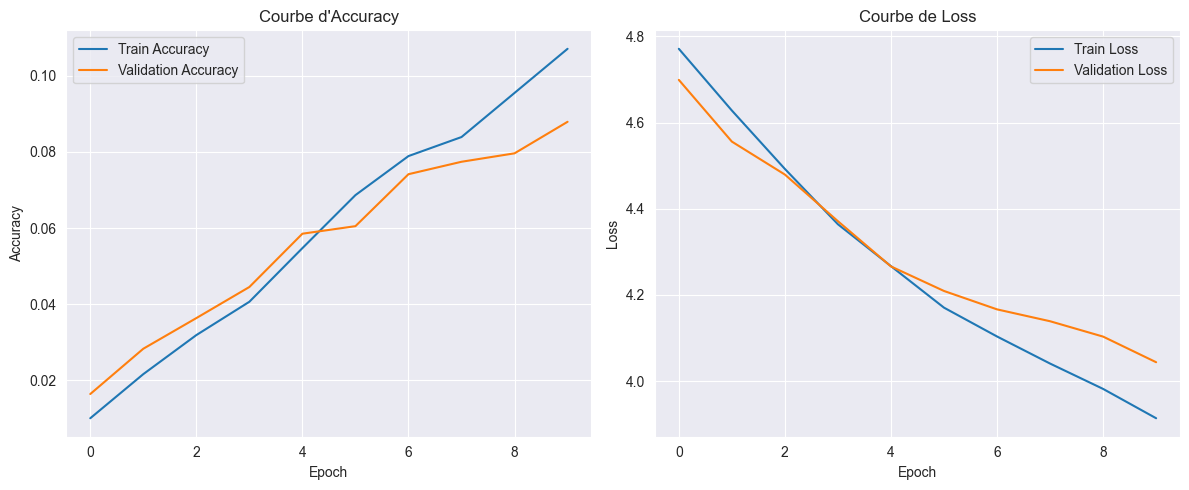

In [6]:
# --- GRAPHIQUES D'ÉVOLUTION ---
plt.figure(figsize=(12, 5))

# Courbe Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe d\'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Courbe Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
